# Quora Question Pairs

The goal of this competition is to predict which of the provided pairs of questions contain two questions with the same meaning. The ground truth is the set of labels that have been supplied by human experts. The ground truth labels are inherently subjective, as the true meaning of sentences can never be known with certainty. Human labeling is also a 'noisy' process, and reasonable people will disagree. As a result, the ground truth labels on this dataset should be taken to be 'informed' but not 100% accurate, and may include incorrect labeling. We believe the labels, on the whole, to represent a reasonable consensus, but this may often not be true on a case by case basis for individual items in the dataset.

Please note: as an anti-cheating measure, Kaggle has supplemented the test set with computer-generated question pairs. Those rows do not come from Quora, and are not counted in the scoring. All of the questions in the training set are genuine examples from Quora.

<a> href="https://www.datacamp.com/community/tutorials/markdown-in-jupyter-notebook"> tricks to use jupyter notebook </a>

## EDA - Quora Question Pairs

In [153]:
import pandas as pd
import os
import re
from tqdm import tqdm
import sqlite3
from pathlib import Path
from numpy import array
import seaborn as sns

In [6]:
#read all the file in the current folder 
list_of_files_in_the_current_dircetory = os.listdir(path=os.getcwd())
list_of_files_in_the_current_dircetory

['.DS_Store',
 'Quora Question Pairs.ipynb',
 'test.csv',
 'test 2.csv',
 'train.csv',
 '.ipynb_checkpoints',
 'sample_submission.csv']

In [12]:
file_info_dic = {}
for file in tqdm(list_of_files_in_the_current_dircetory):
    if re.findall('.csv', str(file)):
        file_info_dic[file] = pd.read_csv(file).shape
file_info_dic

100%|██████████| 7/7 [00:11<00:00,  1.60s/it]


{'test.csv': (2345796, 3),
 'test 2.csv': (3563475, 3),
 'train.csv': (404290, 6),
 'sample_submission.csv': (2345796, 2)}

In [17]:
# https://mungingdata.com/sqlite/create-database-load-csv-python/

Path('quora.db').touch()

conn = sqlite3.connect('quora.db')

# load the data into a Pandas DataFrame
users = pd.read_csv('train.csv')
# write the data to a sqlite table
users.to_sql('train', conn, if_exists='append', index = False)
conn.cursor().execute('''SELECT count(*) FROM train''').fetchall()    

[(404290,)]

In [22]:
# https://www.kite.com/python/answers/how-to-list-tables-using-sqlite3-in-python
list_of_table = conn.cursor().execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
list_of_table

[('train',)]

In [28]:
# https://www.sqlitetutorial.net/sqlite-tutorial/sqlite-describe-table/
description_of_table = {}

for table in tqdm(list_of_table):
    description_of_table[table[0]] = conn.cursor().execute("pragma table_info({})".format(table[0])).fetchall() 

description_of_table

100%|██████████| 1/1 [00:00<00:00, 711.74it/s]


{'train': [(0, 'id', 'INTEGER', 0, None, 0),
  (1, 'qid1', 'INTEGER', 0, None, 0),
  (2, 'qid2', 'INTEGER', 0, None, 0),
  (3, 'question1', 'TEXT', 0, None, 0),
  (4, 'question2', 'TEXT', 0, None, 0),
  (5, 'is_duplicate', 'INTEGER', 0, None, 0)]}

In [90]:
# Data analysis 
# https://www.kite.com/python/docs/sqlite3.Connection.row_factory
# https://docs.python.org/3/library/sqlite3.html#row_factory
# https://www.sqlservertutorial.net/sql-server-basics/sql-server-find-duplicates/


def dict_factory(cursor, row):
    d = {}
    for idx, col in enumerate(cursor.description):
        d[col[0]] = row[idx]
    return d


con = sqlite3.connect('quora.db')
con.row_factory = dict_factory
cur = con.cursor()
dict_of_sql_query = {
    "number_of_classifier":"SELECT COUNT(*) FROM train GROUP BY is_duplicate ORDER BY is_duplicate DESC",
    "unique_question_qid1": "SELECT DISTINCT COUNT(qid1) FROM train",
    "unique_question_qid2": "SELECT DISTINCT COUNT(qid2) FROM train",
    "duplicate_question_qid1_and_qid2": "SELECT qid1, qid2, COUNT(*) Occurrences FROM train GROUP BY qid1, qid2 HAVING COUNT(*) > 1",
    "unique_question_ques1": "SELECT DISTINCT COUNT(question1) FROM train",
    "unique_question_ques2": "SELECT DISTINCT COUNT(question2) FROM train",
    "total_unique_question": "SELECT DISTINCT COUNT(*) FROM (SELECT DISTINCT qid1 FROM train UNION SELECT DISTINCT qid2 FROM train)",
    "max_repetitive_question_frequency": "SELECT id, MAX(count) FROM (SELECT id, COUNT(id) as count FROM (SELECT qid1 id FROM train UNION ALL SELECT qid2 id FROM train) GROUP BY id HAVING COUNT(id) > 1)"
}

result = {}


for key, sql_query in tqdm(dict_of_sql_query.items()):
    result[key] = cur.execute(sql_query).fetchall()  

result

100%|██████████| 8/8 [00:01<00:00,  5.96it/s]


{'number_of_classifier': [{'COUNT(*)': 149263}, {'COUNT(*)': 255027}],
 'unique_question_qid1': [{'COUNT(qid1)': 404290}],
 'unique_question_qid2': [{'COUNT(qid2)': 404290}],
 'duplicate_question_qid1_and_qid2': [],
 'unique_question_ques1': [{'COUNT(question1)': 404289}],
 'unique_question_ques2': [{'COUNT(question2)': 404288}],
 'total_unique_question': [{'COUNT(*)': 537933}],
 'max_repetitive_question_frequency': [{'id': 2559, 'MAX(count)': 157}]}

## Basic feature

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [144]:
sql_query_for_frequency_of_question1 = """
SELECT count FROM
train T
INNER JOIN (
    SELECT qid1 AS id, count(qid1) as count 
    FROM train
    GROUP BY qid1
    ) AS Q
ON T.qid1 = Q.id 
"""

sql_query_for_frequency_of_question2 = """
SELECT count FROM
train T
INNER JOIN (
    SELECT qid2 AS id, count(qid2) as count 
    FROM train
    GROUP BY qid2
    ) AS Q
ON T.qid2 = Q.id 
"""
list_of_sql_query = [sql_query_for_frequency_of_question1, sql_query_for_frequency_of_question2]

In [146]:
basic_feature = []
sql_query_result = []
for sql_query in tqdm(list_of_sql_query):
    sql_query_result = conn.cursor().execute(sql_query).fetchall()
    sql_query_result = [row[0] for row in sql_query_result]
    basic_feature.append(sql_query_result)
    sql_query_result = []
 
frequency_of_question1 = basic_feature[0]
frequency_of_question2 = basic_feature[1]


100%|██████████| 2/2 [00:01<00:00,  1.03it/s]


In [147]:
sql_query_for_question1 = """
SELECT question1 FROM
train
"""

sql_query_for_question2 = """
SELECT question2 FROM
train 
"""
list_of_question1 = [row [0] for row in conn.cursor().execute(sql_query_for_question1).fetchall()]
list_of_question2 = [row [0] for row in conn.cursor().execute(sql_query_for_question2).fetchall()]

In [148]:
character_in_question1 = [len(str(row)) for row in list_of_question1]
character_in_question2 = [len(str(row)) for row in list_of_question2]

In [149]:
word_in_question1 = [len(str(row).split(' ')) for row in list_of_question1]
word_in_question2 = [len(str(row).split(' ')) for row in list_of_question2]

In [150]:
common_words_in_both_questions = [len(set(str(question1).split(' ')).intersection(str(question2).split(' '))) 
                                  for question1, question2 in zip(list_of_question1, list_of_question2)]
total_words_in_both_questions = [len(set(str(question1).split(' ')).union(str(question2).split(' ')))
                                  for question1, question2 in zip(list_of_question1, list_of_question2)]
common_share_word_percentage = [(common/total) if common != 0 and total != 0 else 0 
                                for common, total in zip(common_words_in_both_questions, total_words_in_both_questions)]


In [152]:
sum_of_frequency = [(int(count1)+int(count2)) for count1, count2 in zip(frequency_of_question1, frequency_of_question2)]
difference_of_frequency = [abs(int(count1)-int(count2)) for count1, count2 in zip(frequency_of_question1, frequency_of_question2)]



In [176]:
training_df = pd.read_csv('train.csv')
is_duplicate = training_df['is_duplicate'].to_list()
basic_features_id = training_df['id'].to_list()

In [177]:
# column = ["frequency_of_question1", "frequency_of_question2", "character_in_question1", "character_in_question2",
#          "word_in_question1", "word_in_question2", "common_words_in_both_questions", "total_words_in_both_questions",
#          "common_share_word_percentage", "sum_of_frequency", "difference_of_frequency"]
# training_feature_df = pd.DataFrame([frequency_of_question1, frequency_of_question2, character_in_question1, character_in_question2,
#          word_in_question1, word_in_question2, common_words_in_both_questions, total_words_in_both_questions,
#          common_share_word_percentage, sum_of_frequency, difference_of_frequency], columns=column)

basic_features_dict = {
    "frequency_of_question1": frequency_of_question1,
    "frequency_of_question2": frequency_of_question2,
    "character_in_question1": character_in_question1,
    "character_in_question2": character_in_question2,
    "word_in_question1": word_in_question1,
    "word_in_question2": word_in_question2,
    "common_words_in_both_questions": common_words_in_both_questions,
    "total_words_in_both_questions": total_words_in_both_questions,
    "common_share_word_percentage": common_share_word_percentage,
    "sum_of_frequency": sum_of_frequency,
    "difference_of_frequency": difference_of_frequency,
    "is_duplicate": is_duplicate,
    "id": basic_features_id
}
training_feature_df = pd.DataFrame(data=basic_features_dict)
training_feature_df.shape

(404290, 13)

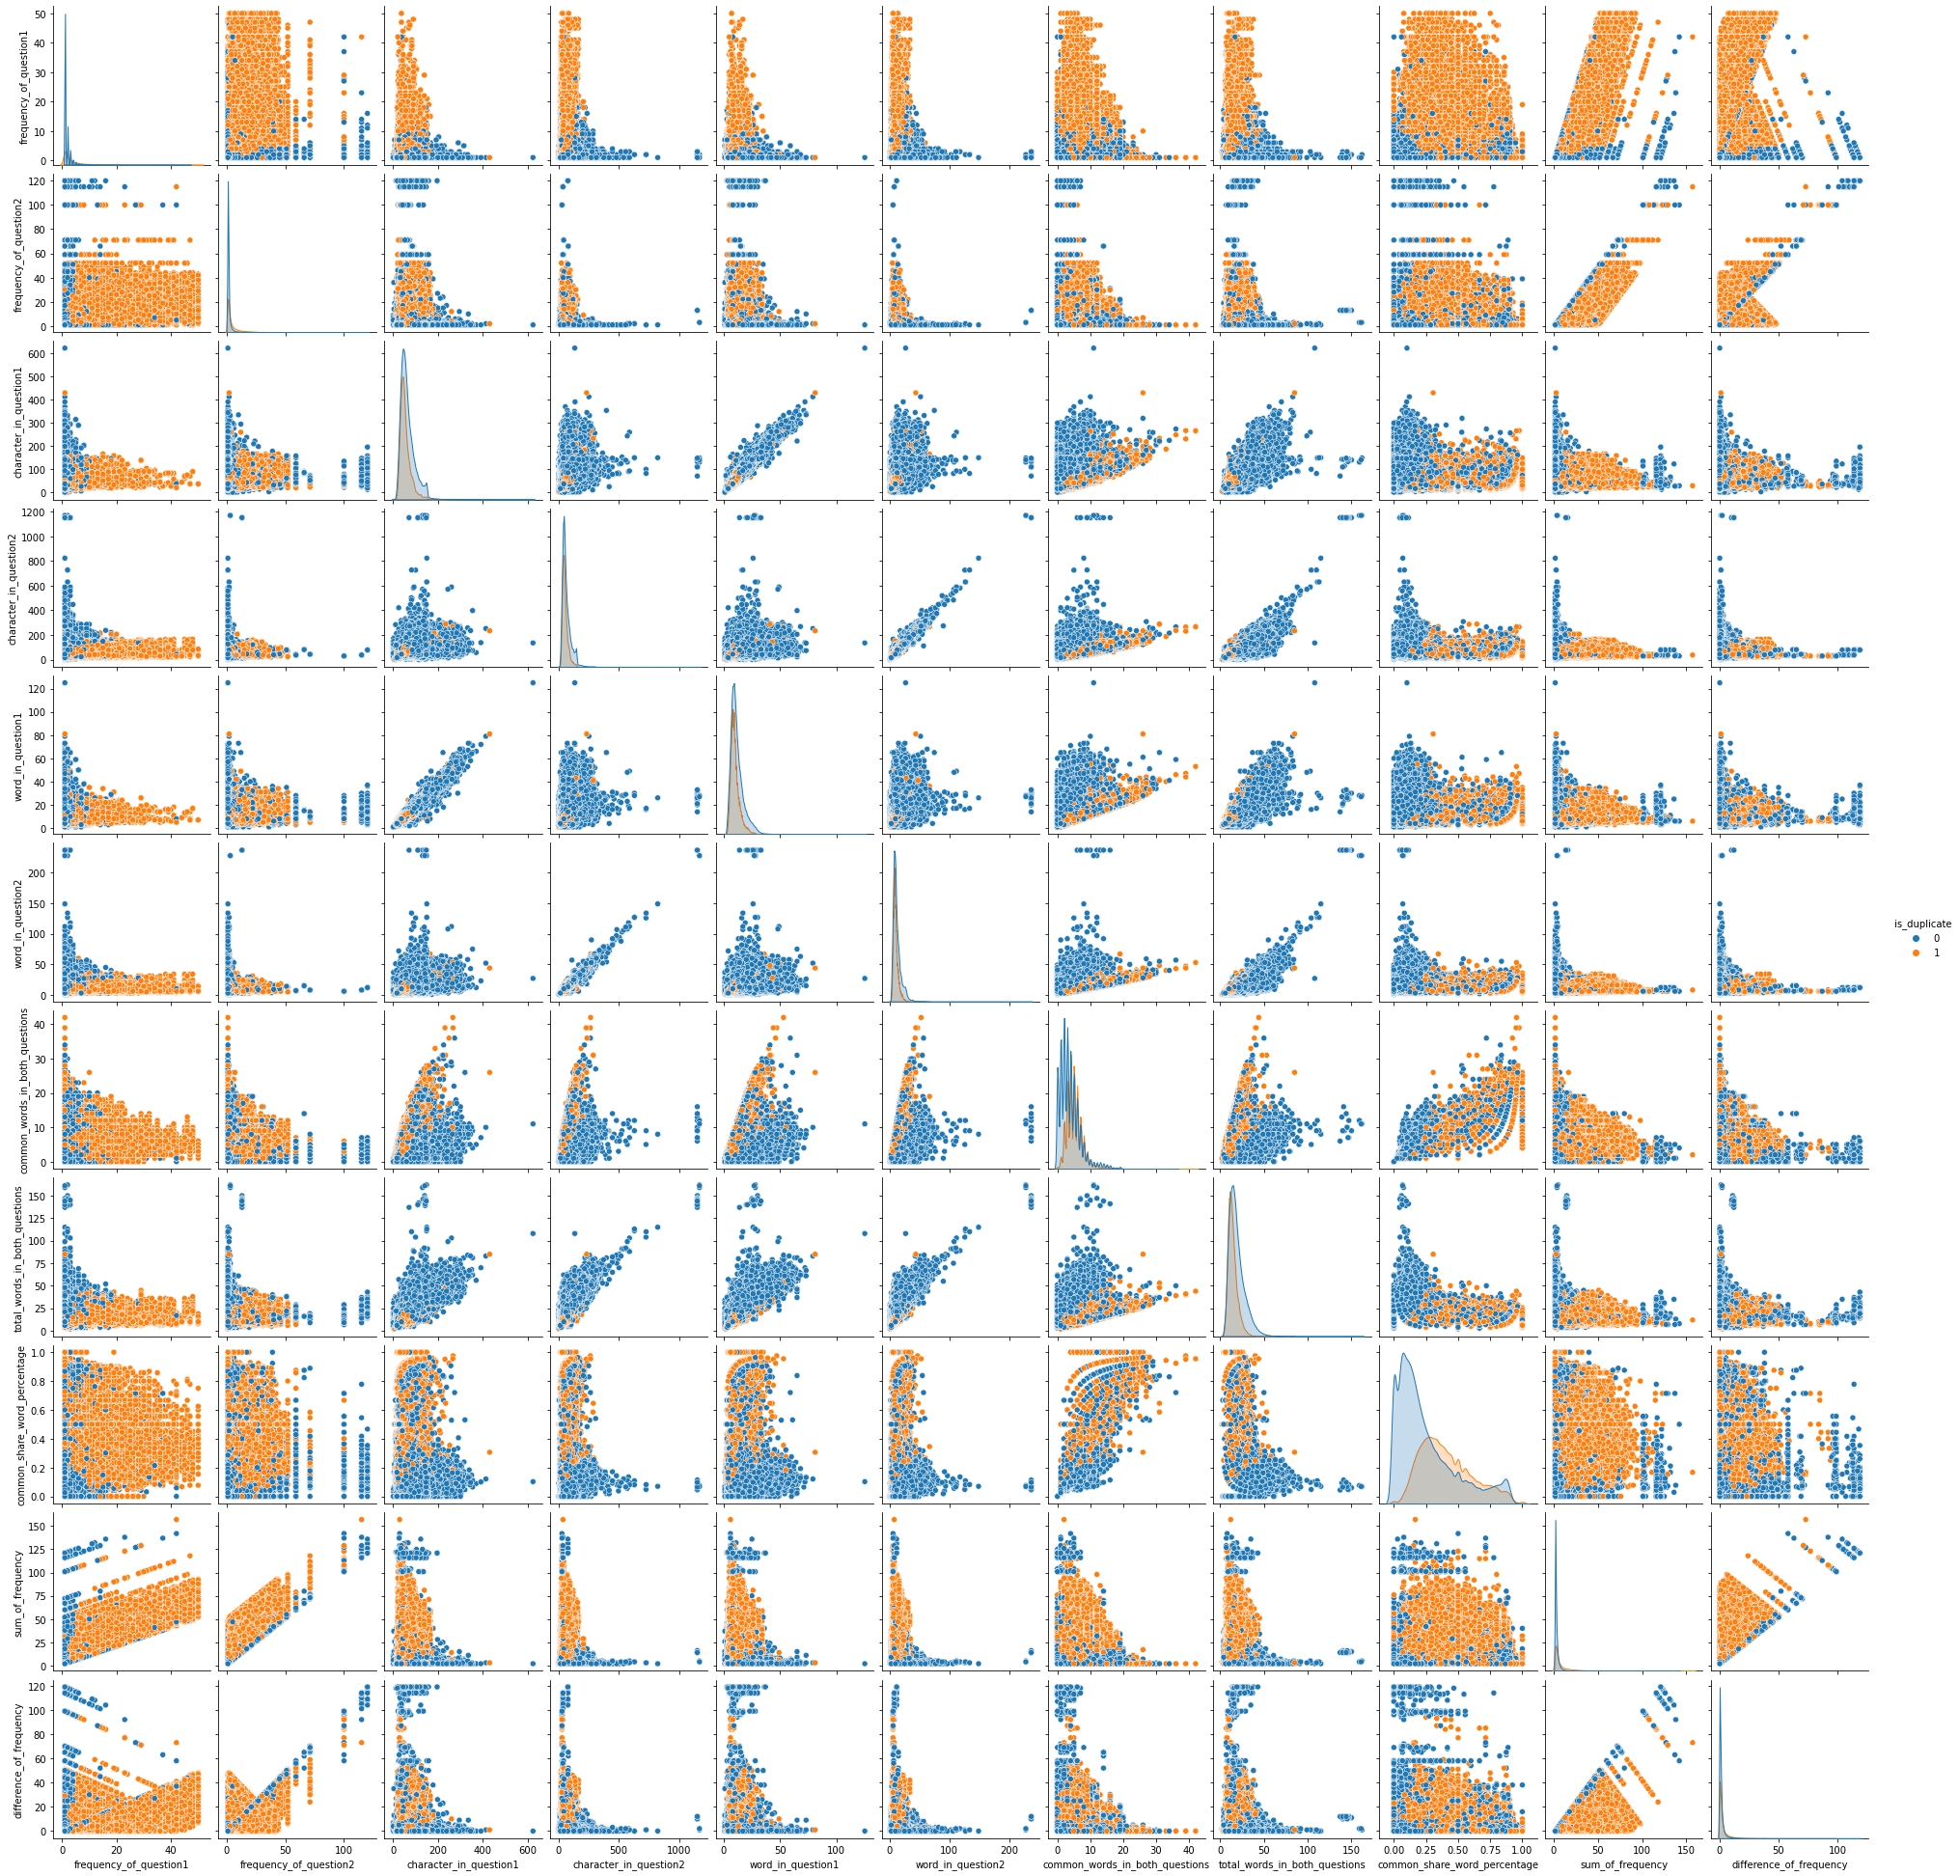

In [163]:
sns.pairplot(training_feature_df, hue='is_duplicate')

In [178]:
training_feature_df.to_csv('training_feature.csv')

In [175]:
frequency_of_character = {}
for question1, question2 in zip(training_df["question1"].to_list(), training_df["question2"].to_list()):
    for c in str(question1).lower():
        if c in frequency_of_character:
            frequency_of_character[c] += 1
        else:
            frequency_of_character[c] = 1
    for c in str(question2).lower():
        if c in frequency_of_character:
            frequency_of_character[c] += 1
        else:
            frequency_of_character[c] = 1
            
print(frequency_of_character)
frequency_of_character = pd.DataFrame.from_dict(frequency_of_character, orient='index')        
frequency_of_character.to_json("frequency_of_character.json")


{'w': 1261813, 'h': 2078002, 'a': 3333412, 't': 3227508, ' ': 8138241, 'i': 3022293, 's': 2436991, 'e': 4354947, 'p': 830436, 'b': 607484, 'y': 790355, 'g': 782929, 'u': 998426, 'd': 1405659, 'o': 3226460, 'n': 2577915, 'v': 376368, 'r': 2225368, 'm': 1047035, 'k': 335327, '?': 852404, 'f': 785058, '(': 25788, '-': 36280, ')': 25905, 'l': 1402348, 'c': 1217241, '[': 3329, ']': 3324, '2': 47750, '3': 19867, '^': 2266, '{': 1902, '4': 15162, '}': 1901, '/': 22033, ',': 101731, 'q': 60578, 'x': 86232, ':': 14398, '.': 74530, "'": 84226, 'シ': 2, 'し': 12, '"': 36752, '&': 4683, '0': 108405, 'j': 68731, '’': 4075, '1': 64094, 'z': 30464, '9': 8721, '5': 29023, ';': 695, '8': 8950, '6': 19214, '7': 12579, '#': 797, '‘': 345, '@': 499, '£': 102, 'ö': 71, '₹': 1036, '$': 2461, '–': 258, '!': 1125, '=': 2164, '\\': 2224, '“': 1308, '”': 1371, '%': 2234, '+': 6363, 'é': 1417, '…': 551, '_': 833, 'ü': 48, 'ã': 97, 'í': 136, '？': 134, 'ذ': 4, 'ل': 26, 'ي': 25, '<': 259, '*': 904, '€': 44, '>': 304,